# Image Sequence Processing

In [1]:
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plot
import matplotlib.patches as patches

import itertools

### Question 1: Implement a Harris Corner Detector

In [2]:
def get_structure_matrix(image, location, window_size):
    image_row, image_col = location
    height, width = window_size

    subimage = image[
        image_row - (height//2) : image_row + (height//2),
        image_col - (width//2) : image_col + (width//2)
    ]

    [x_gradient, y_gradient] = np.gradient(subimage, axis=(0, 1))
        
    return np.array([
        [np.sum(x_gradient ** 2), np.sum(x_gradient * y_gradient)],
        [np.sum(x_gradient * y_gradient), np.sum(y_gradient ** 2)]
    ])

def get_orientation(vector):
    return np.arccos(np.dot(vector, np.array([1, 0]))) * 180 / np.pi

def corner_response(matrix, k=0.05):
    return np.linalg.det(matrix) - k * (np.trace(matrix) ** 2)

def create_corner_ellipse(structure_matrix, location):
    row, col = location

    eigenvalues, eigenvectors = np.linalg.eigh(structure_matrix)

    min_eigenvalue = np.min(eigenvalues)
    max_eigenvalue = np.max(eigenvalues)

    assert min_eigenvalue > 0 and max_eigenvalue > 0

    width = min_eigenvalue ** -0.5 if min_eigenvalue > 1 else 1
    height = max_eigenvalue ** -0.5 if max_eigenvalue > 1 else 1
    orientation = get_orientation(eigenvectors[np.argmax(eigenvalues)])

    return patches.Ellipse(
        (col, row), width, height, orientation,
        edgecolor="yellow", facecolor=None,
        linewidth=0.5, fill=None
    )

def create_corner_rectangle(location, width=1.2, height=1.2):
    row, col = location

    x_coord = col - (width / 2)
    y_coord = row - (height / 2)

    return patches.Rectangle(
        (x_coord, y_coord), width=width, height=width,
        edgecolor="red", facecolor=None,
        fill=None, linewidth=0.75
    )

def get_local_maxima(matrix, location, window_size):
    height, width = window_size
    i, j = location

    submatrix = matrix[
        i - (height // 2) : i + (height // 2) + 1,
        j - (width // 2) : j + (width // 2) + 1
    ]
    
    max_value = None
    max_row, max_col = (0, 0)

    for row in range(height):
        for col in range(width):
            value = submatrix[row, col]
            if max_value is None or value > max_value:
                max_value = value
                max_row, max_col = row, col

    return max_row + i - (height // 2), max_col + j - (width // 2)

def harris_corner_detector(image, window_size):
    image_height, image_width = image.shape

    window_height, window_width = window_size
    height_margin, width_margin = window_height // 2, window_width // 2
    
    responses = np.zeros((image_height, image_width))

    vertical_pixels = range(height_margin, image_height - height_margin)
    horizontal_pixels = range(width_margin, image_width - width_margin)

    for (i, j) in itertools.product(vertical_pixels, horizontal_pixels):
        structure_matrix = get_structure_matrix(image, (i, j), window_size)
        responses[i, j] = corner_response(structure_matrix)

    corner_patches = []
    maximas = []

    for (i, j) in itertools.product(vertical_pixels, horizontal_pixels):
        response_coords = get_local_maxima(responses, (i, j), window_size)

        if response_coords not in maximas:
            #corner_patches.append(create_corner_ellipse((i, j)))
            corner_patches.append(create_corner_rectangle(response_coords))
            maximas.append(response_coords)
    
    return maximas, corner_patches
        

### Question 2: Apply Harris Detector to two images.

libpng warning: sBIT: invalid


Finding corners for image 1.
    - Done.


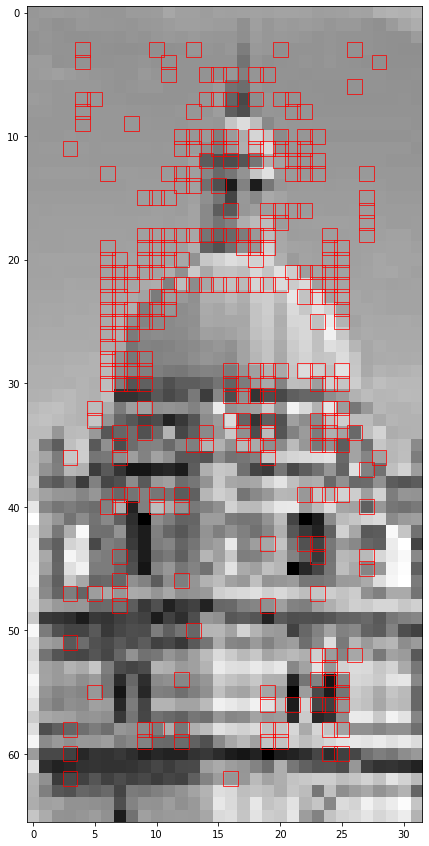

In [8]:
small_image = cv.imread("./small_image.png", 0)

small_image_fig, small_image_ax = plot.subplots()
plot.imshow(small_image, cmap='gray')

print(f"Finding corners for image 1.")
corners, corner_patches = harris_corner_detector(small_image, (7, 7))
print(f"    - Done.")

for corner in corner_patches:
    small_image_ax.add_patch(corner)

small_image_fig.set_size_inches(20, 15)

plot.show()

### Question 3: Apply SIFT to images.

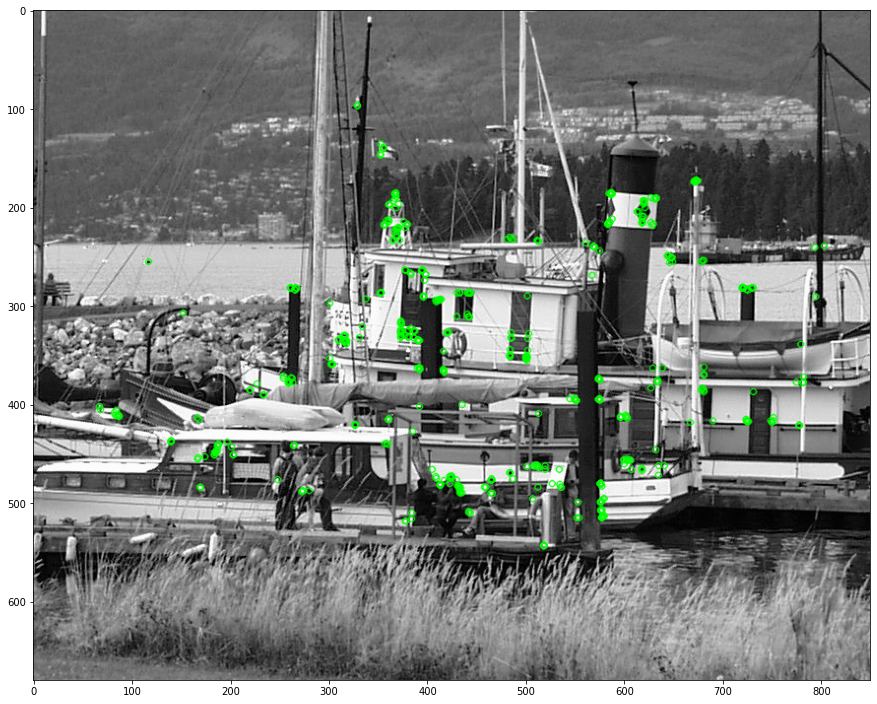

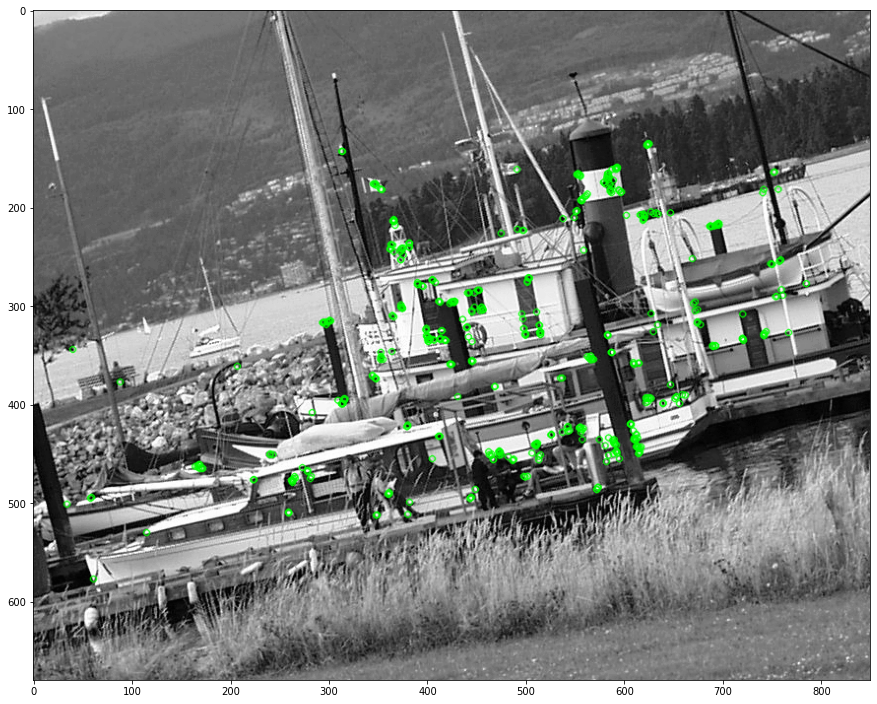

In [9]:
boat_image_1 = cv.imread("./img1.pgm", 0)
boat_image_2 = cv.imread("./img2.pgm", 0)

orb = cv.ORB_create()

# detect the key points and corresponding feature descriptor
keypoints_1, descriptor_1 = orb.detectAndCompute(boat_image_1, None)
keypoints_2, descriptor_2 = orb.detectAndCompute(boat_image_2, None)

# draw the key points
boat_image_1_keypoints = cv.drawKeypoints(boat_image_1, keypoints_1, None, [0, 255, 0], flags=0)
boat_image_2_keypoints = cv.drawKeypoints(boat_image_2, keypoints_2, None, [0, 255, 0], flags=0)

image_1_fig, image_1_axis = plot.subplots()
image_1_axis.imshow(boat_image_1_keypoints)
image_1_fig.set_size_inches(15, 15)

image_2_fig, image_2_axis = plot.subplots()
image_2_axis.imshow(boat_image_2_keypoints)
image_2_fig.set_size_inches(15, 15)

plot.show()
